#### **Import necessary libraries**

In [148]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#### **Load data**

In [149]:
file_path = "../resources/data/output/customer_churn_prepared.csv"
df = pd.read_csv(file_path)

In [150]:

# Display the first few rows of the dataset
df.head()

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_SMS,distinct_called_numbers,age_group,tariff_plan,status,customer_value,churn
0,8,0,38,0,4370,5,17,3,1,1,197.640,0
1,0,0,39,0,318,7,4,2,1,2,46.035,0
2,10,0,37,0,2453,359,24,3,1,1,1536.520,0
3,10,0,38,0,4198,1,35,1,1,1,240.020,0
4,3,0,38,0,2393,2,33,1,1,1,145.805,0


#### **Input and Target Features**

In [151]:
X = df.drop(columns=["churn"])

In [152]:
y = df["churn"]

#### **Numeric and Categorical features**

In [153]:
numeric_features = [
    "call_failure",
    "subscription_length",
    "complains",
    "seconds_of_use",
    "frequency_of_SMS",
    "distinct_called_numbers",
    "charge_amount",
    "customer_value"
]
categorical_features = ["status", "tariff_plan", "age_group"]

#### **Functions**

In [154]:
# Plot ROC AUC curve
def plot_roc_auc(y_test, y_prob, label):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(y_test, y_prob):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [155]:
def train_svm(X, y, num_f, cat_f, kernel='linear', degree=3, label="Model"):
    # 1. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 2. Preprocessor
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_f),
        ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore'), cat_f)
    ])

    # 3. Full Pipeline with SMOTE
    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", SVC(kernel=kernel, degree=degree, probability=True, random_state=42))
    ])

    # 4. Train
    pipeline.fit(X_train, y_train)

    # 5. Predict
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # 6. Evaluation
    print(f"\nClassification Report ({label} + SMOTE):")
    print(classification_report(y_test, y_pred))
    print(f"AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

    return pipeline, y_test, y_prob

#### **Base Model with Linear Kernel**

In [156]:
# Train SVM model for 'linear'
pipeline, y_test_l, y_prob_l = train_svm(
    X,
    y,
    numeric_features,
    categorical_features,
    kernel='linear',
    degree=1,
    label="SVM Linear"
)


Classification Report (SVM Linear + SMOTE):
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       473
           1       0.47      0.80      0.60        80

    accuracy                           0.84       553
   macro avg       0.72      0.82      0.75       553
weighted avg       0.89      0.84      0.86       553

AUC Score: 0.9262


- For Non-Churned Customers (0):
    - High precision (0.96): Very reliable when predicting customers will stay.
    - Good recall (0.85): Captures most non-churning customers.
- For Churned Customers (1):
    - Lower precision (0.47): Some false positives when predicting churn.
    - Strong recall (0.80): Successfully identifies most churners.

The high AUC score of 0.9262 indicates excellent model discrimination ability.

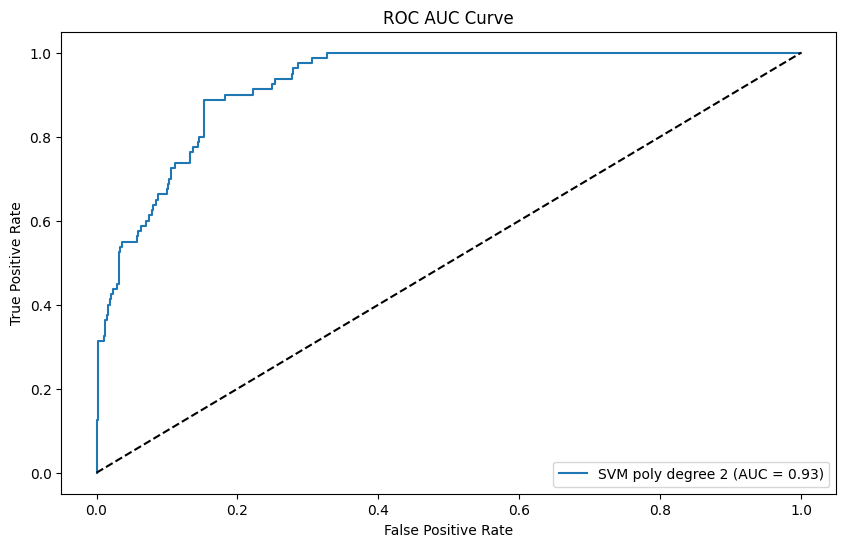

In [157]:
# Plot ROC AUC curve
plot_roc_auc(y_test_l, y_prob_l, label="SVM poly degree 2")

The ROC (Receiver Operating Characteristic) curve shows excellent model performance:

- High AUC score of 0.93, indicating strong discrimination ability between churned and non-churned customers
- Curve rises sharply at low false positive rates, showing the model can identify many true churners with minimal false alarms
- Significant separation from the diagonal dashed line, confirming the model's predictive power

#### **Base Model with with poly Kernel and degree=2**

In [158]:
pipeline, y_test_p, y_prob_p = train_svm(
    X,
    y,
    numeric_features,
    categorical_features,
    kernel='poly',
    degree=2,
    label="SVM poly degree=2"
)


Classification Report (SVM poly degree=2 + SMOTE):
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       473
           1       0.50      0.89      0.64        80

    accuracy                           0.85       553
   macro avg       0.74      0.87      0.77       553
weighted avg       0.91      0.85      0.87       553

AUC Score: 0.9372


- For Non-Churned Customers (0):
    - Very high precision (0.98): Almost perfect at identifying true non-churners
    - Good recall (0.85): Successfully captures 85% of actual non-churners
- For Churned Customers (1):
    - Moderate precision (0.50): Some false positives when predicting churn
    - Excellent recall (0.89): Captures 89% of actual churners

The high AUC score of 0.937 and overall accuracy of 0.85 show strong model performance. This polynomial kernel performs slightly better than the linear SVM, particularly in recall for churned customers (0.89 vs 0.80).

#### **Base Model with with poly Kernel and degree=3**

In [159]:
pipeline, y_test_p, y_prob_p = train_svm(
    X,
    y,
    numeric_features,
    categorical_features,
    kernel='poly',
    degree=3,
    label="SVM poly degree=3"
)


Classification Report (SVM poly degree=3 + SMOTE):
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       473
           1       0.54      0.88      0.67        80

    accuracy                           0.87       553
   macro avg       0.76      0.87      0.79       553
weighted avg       0.91      0.87      0.88       553

AUC Score: 0.9596


- For Non-Churned Customers (0):
    - High precision (0.98): Almost perfect at identifying true non-churners
    - Strong recall (0.87): Successfully captures 87% of actual non-churners
- For Churned Customers (1):
    - Moderate precision (0.54): Some false positives when predicting churn
    - Strong recall (0.88): Captures 88% of actual churners

With an overall accuracy of 0.87 and AUC score of 0.960, this model performs significantly better than the linear and degree=2 versions.

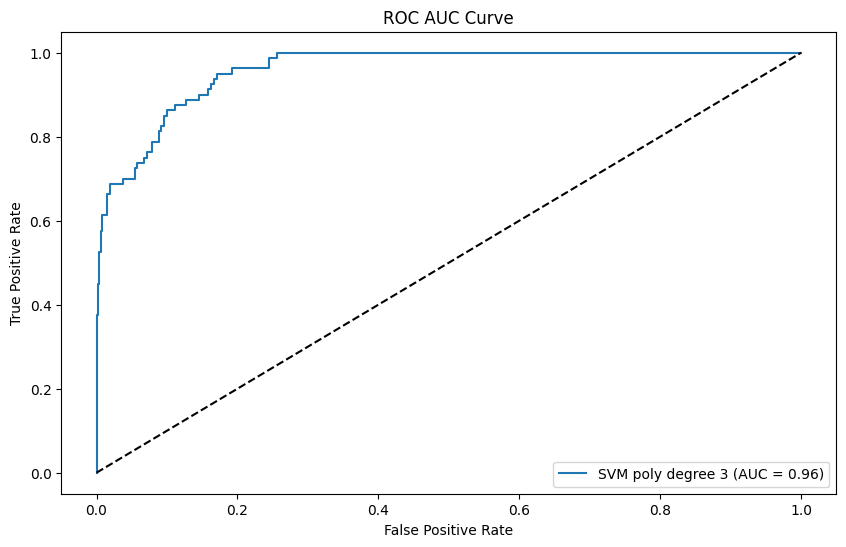

In [160]:
# Plot ROC AUC curve
plot_roc_auc(y_test_p, y_prob_p, label="SVM poly degree 3")

#### **Base Model with with RBF Kernel**

In [161]:
# Train SVM model for 'RBF'
pipeline_rbf, y_test_rbf, y_prob_rbf = train_svm(
    X,
    y,
    numeric_features,
    categorical_features,
    kernel='rbf',
    label="SVM RBF"
)


Classification Report (SVM RBF + SMOTE):
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       473
           1       0.53      0.95      0.68        80

    accuracy                           0.87       553
   macro avg       0.76      0.90      0.80       553
weighted avg       0.92      0.87      0.88       553

AUC Score: 0.9621


- For Non-Churned Customers (0):
    - Nearly perfect precision (0.99): Almost no false positives when predicting non-churners
    - Strong recall (0.86): Successfully identifies 86% of actual non-churners
- For Churned Customers (1):
    - Moderate precision (0.53): Some false positives when predicting churn
    - Excellent recall (0.95): Captures 95% of actual churners, highest among all SVM variants

With an overall accuracy of 0.87 and the highest AUC score (0.9621) among all SVM variants, the RBF kernel provides the best balance of performance metrics, particularly excelling at identifying potential churners while maintaining high precision for non-churners.

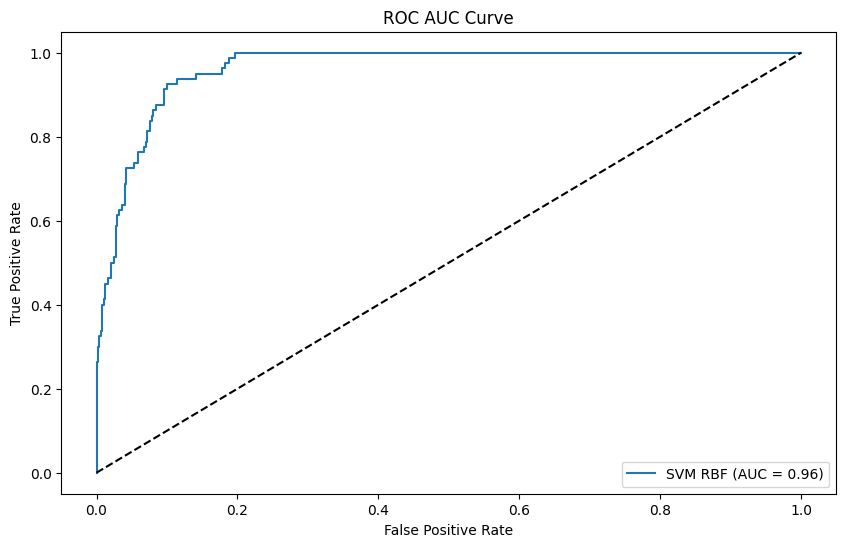

In [162]:
# Plot ROC AUC curve
plot_roc_auc(y_test_rbf, y_prob_rbf, label="SVM RBF")

#### **Cross Validation**

In [163]:
from sklearn.model_selection import StratifiedKFold, cross_validate


# Function to evaluate SVM model using Stratified K-Fold CV with SMOTE
def evaluate_svm_pipeline_cv(X, y, num_f, cat_f, model_label="RBF_SVM", k=5, kernel="rbf", degree=3):
    #1. Preprocessing steps: scale numeric and one-hot encode categorical
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), num_f),
        ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), cat_f)
    ])

    # 2. Define pipeline: Preprocessing → SMOTE → SVM classifier
    pipeline = ImbPipeline([
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("classifier", SVC(kernel=kernel, degree=degree, probability=True, random_state=42))
    ])

    # 3. Define Stratified K-Fold to preserve churn ratio in each fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # 4. Evaluate the pipeline using cross-validation on AUC, Recall, F1
    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=skf,
        scoring=["roc_auc", "recall", "f1"],
        return_train_score=False
    )

    # 5. Print metrics for each fold
    for i in range(k):
        print(f"\n Fold {i+1} | AUC: {scores['test_roc_auc'][i]:.4f} | Recall: {scores['test_recall'][i]:.4f} | F1: {scores['test_f1'][i]:.4f}")

    # 6. Print average performance
    print(f"\n {k}-Fold Cross-Validation Results ({model_label}):")
    print(f"Average AUC:    {np.mean(scores['test_roc_auc']):.4f}")
    print(f"Average Recall: {np.mean(scores['test_recall']):.4f}")
    print(f"Average F1:     {np.mean(scores['test_f1']):.4f}")
    return pipeline

In [164]:
pipeline_rbf_cv = evaluate_svm_pipeline_cv(
    X,       
    y,                   
    num_f=numeric_features,           
    cat_f=categorical_features,       
    model_label="SVM RBF",        
    k=5,                              
    kernel="rbf",                     # Kernel type: 'rbf', 'linear', or 'poly'
    degree=3                          # Degree for poly kernel (only used if kernel='poly')
)


 Fold 1 | AUC: 0.9691 | Recall: 0.9750 | F1: 0.6812

 Fold 2 | AUC: 0.9614 | Recall: 0.9625 | F1: 0.6937

 Fold 3 | AUC: 0.9561 | Recall: 0.9625 | F1: 0.6581

 Fold 4 | AUC: 0.9708 | Recall: 0.9630 | F1: 0.7059

 Fold 5 | AUC: 0.9710 | Recall: 0.9383 | F1: 0.7238

 5-Fold Cross-Validation Results (SVM RBF):
Average AUC:    0.9657
Average Recall: 0.9602
Average F1:     0.6925


The 5-fold cross-validation results for SVM with RBF kernel show excellent and consistent performance:

- AUC Scores:
    - Very high average of 0.966
    - Consistent across folds (0.956-0.971)
    - Shows robust model discrimination ability
- Recall Scores:
    - Exceptional average of 0.960
    - Strong consistency (0.938-0.975)
    - Indicates reliable detection of churners
- F1 Scores:
    - Moderate average of 0.693
    - Reasonable range (0.658-0.724)
    - Reflects balance between precision and recall

In [165]:
pipeline_poly_cv = evaluate_svm_pipeline_cv(
    X,       
    y,                   
    num_f=numeric_features,           
    cat_f=categorical_features,       
    model_label="SVM Poly",        
    k=5,                              
    kernel="poly",                    # Kernel type: 'rbf', 'linear', or 'poly'
    degree=3                          # Degree for poly kernel (only used if kernel='poly')
)


 Fold 1 | AUC: 0.9608 | Recall: 0.8750 | F1: 0.6667

 Fold 2 | AUC: 0.9596 | Recall: 0.8875 | F1: 0.6794

 Fold 3 | AUC: 0.9506 | Recall: 0.8875 | F1: 0.6368

 Fold 4 | AUC: 0.9767 | Recall: 0.9383 | F1: 0.7037

 Fold 5 | AUC: 0.9740 | Recall: 0.9259 | F1: 0.7212

 5-Fold Cross-Validation Results (SVM Poly):
Average AUC:    0.9643
Average Recall: 0.9028
Average F1:     0.6815


The 5-fold cross-validation results for SVM with polynomial kernel show strong and consistent performance:

- AUC Scores:
    - High average of 0.964
    - Strong consistency (0.951-0.977)
    - Shows excellent model discrimination ability
- Recall Scores:
    - Strong average of 0.903
    - Good consistency (0.875-0.938)
    - Demonstrates reliable detection of churners
- F1 Scores:
    - Moderate average of 0.682
    - Reasonable range (0.637-0.721)
    - Shows balanced precision and recall

#### **Comparing the 5-fold cross-validation results between RBF and Polynomial kernels**

- **RBF Kernel**:
    - AUC: 0.966 (range: 0.956-0.971)
    - Recall: 0.960 (range: 0.938-0.975)
    - F1: 0.693 (range: 0.658-0.724)
- **Polynomial Kernel**:
    - AUC: 0.964 (range: 0.951-0.977)
    - Recall: 0.903 (range: 0.875-0.938)
    - F1: 0.682 (range: 0.637-0.721)

RBF kernel shows superior performance, particularly in recall (0.960 vs 0.903), meaning it's better at identifying potential churners. While both kernels have similar AUC scores, RBF's higher and more consistent recall makes it the better choice for churn prediction.

#### **Persist the model**

In [166]:
print(X.shape)
X.head()

(2765, 11)


,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_SMS,distinct_called_numbers,age_group,tariff_plan,status,customer_value
0,8,0,38,0,4370,5,17,3,1,1,197.640
1,0,0,39,0,318,7,4,2,1,2,46.035
2,10,0,37,0,2453,359,24,3,1,1,1536.520
3,10,0,38,0,4198,1,35,1,1,1,240.020
4,3,0,38,0,2393,2,33,1,1,1,145.805


In [167]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int64

In [168]:
final_model = pipeline_rbf_cv.fit(X, y)

In [169]:
joblib.dump(final_model, "../resources/models/svm_classifier_pipeline.pkl")

['../resources/models/svm_classifier_pipeline.pkl']